In [1]:
# generic imports
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sn
import h5py
import time
from subprocess import call
import telegram_send
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras import backend as K
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import layers, optimizers
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D, Conv1D, MaxPooling1D, MaxPooling2D, Dropout, ELU
from keras.models import Model, Sequential, model_from_json

sn.set(style="white", context="talk")

from utils import terminate, outdir, load_dataset, show_stats, ohe_to_label, conf_matrix, export_model, f1
from models import m_1d, m_1d2d, m_1d2d_01, m_3d

%matplotlib inline

Using TensorFlow backend.


Available gpus []


In [2]:
##################
##    CONFIG    ##
##################
models_conf = {
    'm_1d': {
        'active': True,
        'is_1d': True,
        'model': m_1d
    },
    'm_3d': {
        'active': False,
        'is_1d': False,
        'model': m_3d
    },
    'm_1d2d': {
        'active': False,
        'is_1d': False,
        'model': m_1d2d
    },
    'm_1d2d_01': {
        'active': False,
        'is_1d': False,
        'model': m_1d2d_01
    }
}

# in datasets name, test and train gets prependend at load time
general_conf = {
    'debug': False,
    'prod': True,
    'export_models': True,
    'batch_size': 32,
    'iterations': 1,
    'datasets': [
        '',
        #'-augmented',
        #'-with-trans'
    ]
}

class_conversion = {
    '0': 'falling',
    '1': 'jumping',
    '2': 'lying',
    '3': 'running',
    '4': 'sitting',
    '5': 'standing',
    '6': 'walking'
}

# Training


### STARTING JOB for dataset  ###

number of training examples = 22836
number of test examples = 5709
X_train shape: (22836, 128, 6)
Y_train shape: (22836, 7)
X_test shape: (5709, 128, 6)
Y_test shape: (5709, 7)

Model summary for m_1d
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 6)            0         
_________________________________________________________________
conv0 (Conv1D)               (None, 124, 30)           930       
_________________________________________________________________
bn0 (BatchNormalization)     (None, 124, 30)           496       
_________________________________________________________________
activation_1 (Activation)    (None, 124, 30)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 30)           0         
_____________________________________

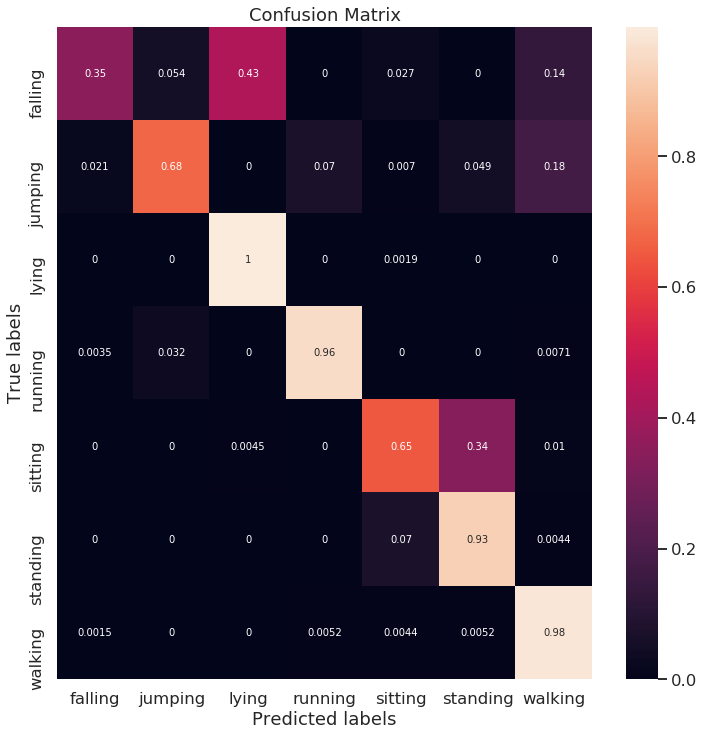

In [3]:
##################
##   TRAINING   ##
##################
datasets_nr = len(general_conf['datasets'])
models_nr = sum([t['active'] for t in models_conf.values()])
total_cycles = datasets_nr * models_nr
cycle = 1

# cycle through the datasets
for data in general_conf['datasets']:
    print()
    print('### STARTING JOB for dataset {} ###'.format(data))
    print()
    
    X_train_o, X_test_o, Y_train, Y_test = load_dataset(data)
    
    # cycle through the models
    for model_name, model in models_conf.items():
        # output name identified by model name and dataset name
        out_name = model_name + data
        
        if model['active']:
            # reshape dataset if needed
            input_shape = []
            if model['is_1d']:
                K.set_image_data_format('channels_last')
                X_train, X_test = X_train_o, X_test_o
                input_shape = [X_train.shape[1], X_train.shape[2]]
            else:
                # using channel_first because channel_last has a bug when used with gpu
                # https://github.com/keras-team/keras/issues/10648
                # with channel first the input has to be
                # (batch, channels, rows, cols), so something like (12000, 1, 128, 6)
                K.set_image_data_format('channels_first')
                X_train = X_train_o.reshape(X_train_o.shape[0], 1, X_train_o.shape[1], X_train_o.shape[2])
                X_test = X_test_o.reshape(X_test_o.shape[0], 1, X_test_o.shape[1], X_test_o.shape[2])
                
                # these are to be used if I'm using channel_last
                # X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
                # X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
                
                input_shape = [X_train.shape[1], X_train.shape[2], X_train.shape[3]]
            
            current_model = model['model'](input_shape)
            #sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            current_model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy', f1])
            print()
            print('Model summary for', model_name)
            print(current_model.summary())

            # if debug is on, stop here and just show the model specifications
            if not general_conf['debug']:
                print('Starting training for model', out_name)
                start_time = time.time()
                callbacks = [
                    # tensorboard config
                    TensorBoard(log_dir='./logs/{}'.format(out_name), histogram_freq=0, write_graph=True, write_images=True),
                    # stop if loss does not decrease after x epochs
                    EarlyStopping(patience=15, monitor='val_loss', min_delta=0, mode='min'),
                    # save best model
                    ModelCheckpoint('{}-weights-chpt.h5'.format(outdir(out_name)), monitor='val_loss', save_best_only=True, save_weights_only=True)
                ]
                
                # train
                history = current_model.fit(
                    x = X_train, y = Y_train,
                    epochs=general_conf['iterations'],
                    batch_size=general_conf['batch_size'],
                    validation_data=(X_test, Y_test),
                    callbacks = callbacks)
                # test
                preds = current_model.evaluate(x = X_test, y = Y_test)
                show_stats(start_time, preds)
                
                # output results
                predictions = current_model.predict(X_test)
                Y_pred = ohe_to_label(predictions)
                Y_true = ohe_to_label(Y_test)
                
                conf_matrix(Y_true, Y_pred, class_conversion, out_name, save = True)
                
                # export model
                if general_conf['export_models']:
                    export_model(current_model, out_name)
                # notify
                telegram_send.send(['Training {}/{} finished'.format(cycle, total_cycles)])
            cycle += 1
                
# send finish signal via telegram and close aws instance
if general_conf['prod']:
    terminate()

# To import a trained model

# Plots (unused)